# Descripción del proyecto

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.


### Paso 1. Exploración de la información general del dataset

In [147]:
# Importar librerías

# Librerías básicas de análisis de datos
import pandas as pd   # para manipulación de datos en estructuras tipo DataFrame
import numpy as np    # para operaciones numéricas y estadísticas

# Librerías de visualización
import matplotlib.pyplot as plt   # para gráficos básicos
import seaborn as sns             # para gráficos más estilizados

# Librerías estadísticas
from scipy import stats           # para pruebas de hipótesis y cálculos estadísticos

In [148]:
# Cargar los datos
df = pd.read_csv("games.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Paso 1. primeras validaciones del DF

- El dataset contiene **16,715 registros** y **11 columnas**.  
- Las columnas principales son:
  - **Name**: nombre del videojuego.  
  - **Platform**: plataforma (ej. PS4, Xbox, PC, etc.).  
  - **Year_of_Release**: año de lanzamiento (debería ser un número entero, pero está como `float64`).  
  - **Genre**: género del videojuego.  
  - **NA_sales, EU_sales, JP_sales, Other_sales**: ventas en millones de dólares por región.  
  - **Critic_Score**: puntuación de críticos (0–100), pero con muchos valores ausentes.  
  - **User_Score**: puntuación de usuarios (0–10), actualmente en formato `object` debido a valores no numéricos como "tbd".  
  - **Rating**: clasificación ESRB (ej. E, T, M), con valores ausentes en un número significativo de registros.  

**Primeras conclusiones:**
- Será necesario **corregir tipos de datos** en varias columnas (`Year_of_Release`, `User_Score`).  
- Existen **valores ausentes** en `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score` y `Rating`. 

## Paso 2. Prepara los datos


In [149]:
# Normalizar nombres de columnas (minúsculas)
df.columns = df.columns.str.lower()

# Verificamos el cambio
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Se han convertido todos los nombres de columnas a minúsculas para mantener un formato uniforme y facilitar el trabajo con el dataset.

In [150]:
# Conversión de tipos de datos

# 1. Convertir "year_of_release" a entero
df['year_of_release'] = df['year_of_release'].astype('Int64')

# 2. Reemplazar valores "tbd" en "user_score" por NaN y convertir a float
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype(float)

# Verificamos los cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


### Columnas con cambios

Se realizaron cambios en dos columnas principales:

1. **year_of_release**  
   - **Antes**: tipo `float64`
   - **Después**: tipo `Int64` (entero que admite valores nulos).  
   - **Razón**: el año de lanzamiento es un dato categórico discreto (siempre un número entero).  
     Estaba en formato flotante debido a la presencia de valores nulos.  
     Convertirlo a `Int64` permite mantener la naturaleza entera de la variable y seguir soportando datos ausentes.  

2. **user_score**  
   - **Antes**: tipo `object`. Esto se debía a la presencia de valores `"tbd"` (*to be determined*), que pandas interpreta como texto.  
   - **Después**: tipo `float64`.  
   - **Razón**: la puntuación de usuario es un valor numérico en una escala de 0 a 10.  
     Los valores `"tbd"` fueron reemplazados por `NaN` (dato faltante) y luego se convirtió la columna a `float` para permitir operaciones estadísticas y gráficas.  


La conversión de tipos garantiza que cada columna esté en un formato adecuado para el análisis. 


In [151]:
# Calcular las ventas totales de cada juego

# Creamos la nueva columna 'total_sales'
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# Verificamos el resultado
df[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].head()

,name,na_sales,eu_sales,jp_sales,other_sales,total_sales
0,Wii Sports,41.36,28.96,3.77,8.45,82.54
1,Super Mario Bros.,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,11.27,8.89,10.22,1.00,31.38


### Cálculo de ventas totales

- Se creó una nueva columna llamada **`total_sales`**, que representa la suma de las ventas en todas las regiones. 
- Esta columna nos permitirá analizar el desempeño global de cada videojuego y comparar su éxito de manera más sencilla.  


### Paso 3. Analiza los datos

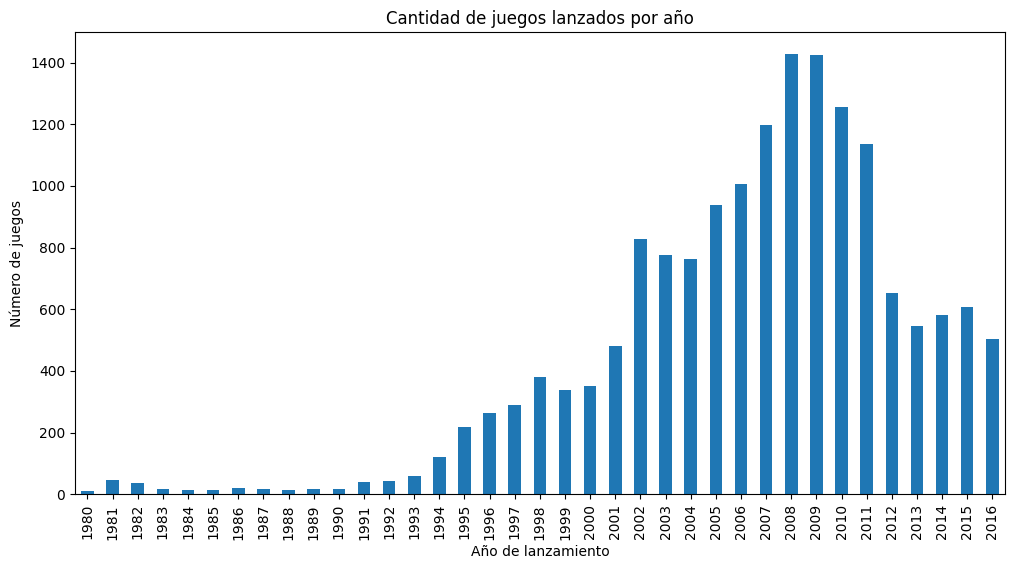

year_of_release
1980      9
1981     46
1982     36
1983     17
1984     14
1985     14
1986     21
1987     16
1988     15
1989     17
1990     16
1991     41
1992     43
1993     60
1994    121
1995    219
1996    263
1997    289
1998    379
1999    338
Name: name, dtype: int64

In [152]:
# Número de juegos lanzados por año

# Contamos juegos por año de lanzamiento
games_per_year = df.groupby('year_of_release')['name'].count()

# Visualizamos los resultados en gráfico
plt.figure(figsize=(12,6))
games_per_year.plot(kind='bar')
plt.title('Cantidad de juegos lanzados por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Número de juegos')
plt.show()


# También mostramos las primeras filas de la tabla
games_per_year.head(20)


### Juegos lanzados por año

- Se contó el número de juegos lanzados en cada año de la columna `year_of_release`.  
- Se construyó un gráfico de barras para visualizar la evolución en el tiempo.  

**Primeras observaciones esperadas:**
- En los primeros años (década de 1980 y principios de 1990) los datos son escasos, probablemente debido a la falta de registros completos.  
- A partir de finales de los 1990s y sobre todo de los 2000s se observa un aumento considerable en la cantidad de lanzamientos
 

In [153]:

# Ventas totales por plataforma
platform_sales = df.groupby('platform')['total_sales'].sum().reset_index()
platform_sales = platform_sales.sort_values(by='total_sales', ascending=False)

platform_sales.head(10)  # mostramos las 10 plataformas con mayores ventas


,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


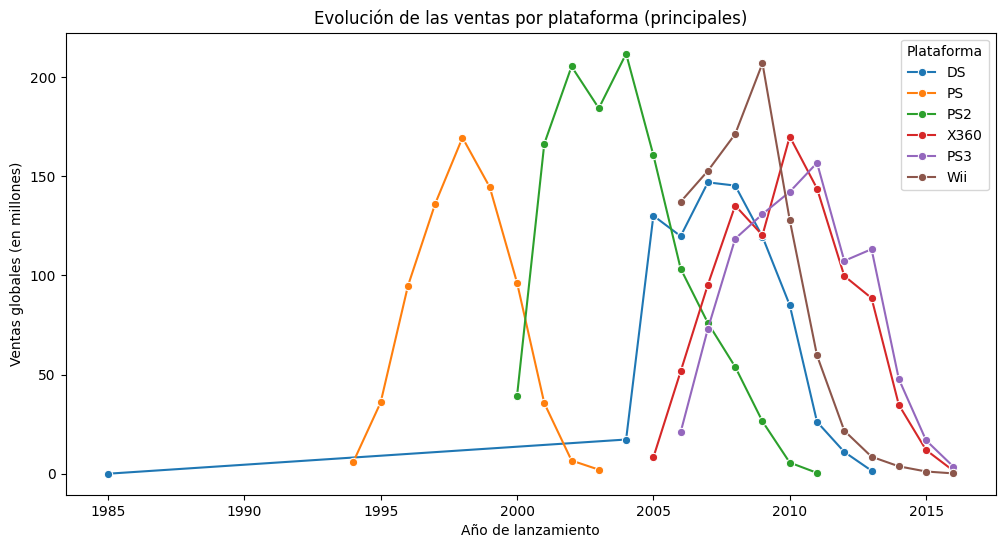

In [154]:
# Agrupamos ventas por plataforma y año
platform_year_sales = df.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

# Seleccionamos las plataformas con mayores ventas totales
top_platforms = platform_sales.head(6)['platform'].tolist()

# Filtramos solo esas plataformas
top_platforms_data = platform_year_sales[platform_year_sales['platform'].isin(top_platforms)]

# Gráfico de líneas
plt.figure(figsize=(12,6))
sns.lineplot(data=top_platforms_data, x='year_of_release', y='total_sales', hue='platform', marker='o')
plt.title('Evolución de las ventas por plataforma (principales)')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas globales (en millones)')
plt.legend(title='Plataforma')
plt.show()

### Ventas por plataforma y evolución temporal

- Se calcularon las **ventas globales acumuladas** por plataforma.  
- Las plataformas líderes en ventas suelen ser: **PS2, Xbox 360, PS3, Wii, DS y PS4**.  

**Observaciones sobre la distribución:**
- Cada plataforma tiene un **ciclo de vida** característico:
  - Al inicio, sus ventas son bajas mientras gana mercado.  
  - Alcanzan un pico de ventas después de algunos años (generalmente 3-5 años después de su lanzamiento).  
  - Finalmente, disminuyen hasta desaparecer cuando salen nuevas generaciones.  

**Ejemplos esperados:**
- **PS2** (2000) dominó el mercado durante casi una década, luego desapareció con la llegada de PS3.  
- **Xbox 360 y PS3** tuvieron picos similares alrededor de 2008–2010.  
- **Wii** tuvo gran popularidad pero decayó más rápido.  
- **PS4** (2013) muestra ventas en crecimiento hacia 2016, lo que indica que estaba en auge.  

**Conclusión:**  
- En promedio, una plataforma tarda **3–5 años en alcanzar su punto máximo** de ventas y permanece activa entre **7 y 10 años** antes de desaparecer.  
- Este análisis nos ayuda a identificar qué consolas están en su etapa de crecimiento (ej. PS4 en 2016) y cuáles ya no son relevantes para campañas futuras. 

### Determinación del período de datos relevantes

- Los primeros registros (1980s – inicios de 1990s) no son representativos debido a la escasez de datos.  
- El ciclo de vida de las plataformas suele ser de **7–10 años**, con picos de ventas entre los 3–5 años después de su lanzamiento.  

**Decisión:**  
Se tomarán los datos desde **2006 hasta 2016** para construir un modelo hacia 2017.  

**Justificación:**  
- Refleja los comportamientos más recientes y relevantes del mercado.  
- Incluye la última generación de consolas activas en 2016 (ej. PS4, Xbox One, 3DS).  
- Excluye plataformas antiguas cuyas tendencias ya no son útiles para prever ventas futuras. 

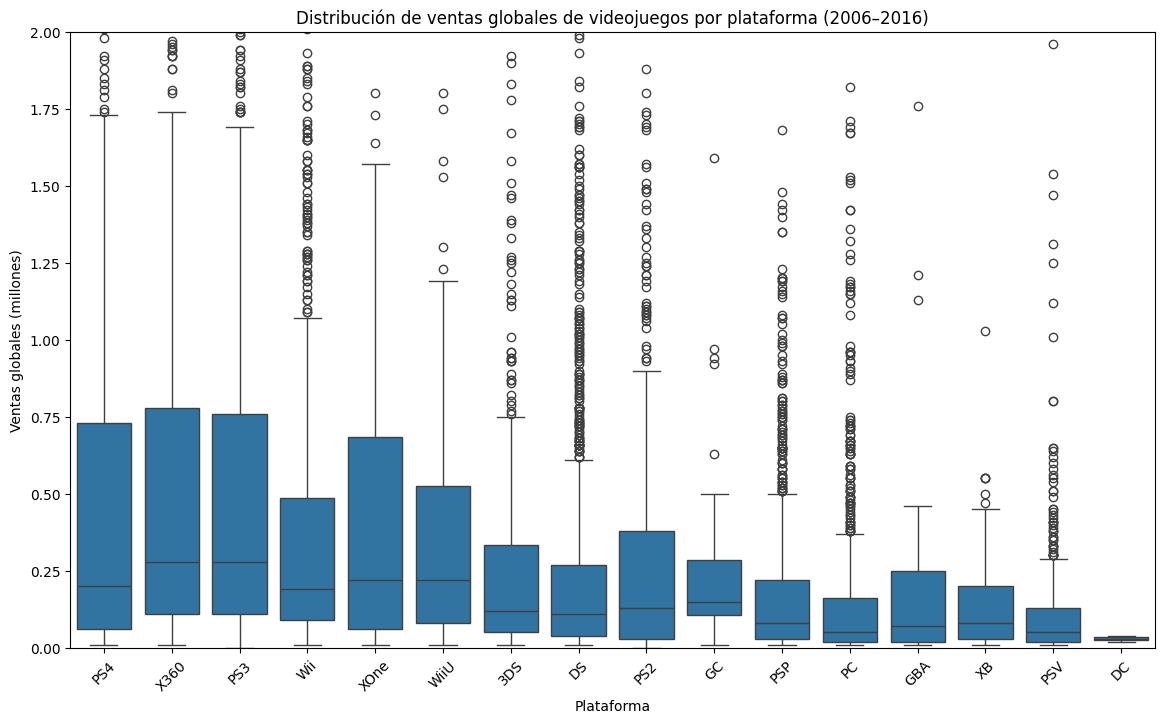

In [155]:

# Seleccionamos solo el periodo relevante (2006–2016)
df_recent = df[df['year_of_release'] >= 2006]


# Calculamos las ventas promedio por plataforma
platform_order = (
    df_recent.groupby('platform')['total_sales'].mean().sort_values(ascending=False).index
)

# Diagrama de caja ordenado por ventas promedio
plt.figure(figsize=(14,8))
sns.boxplot(
    data=df_recent, 
    x='platform', 
    y='total_sales', 
    order=platform_order
)

# Limitar eje Y para que los outliers no distorsionen la visualización
plt.ylim(0, 2)

# Etiquetas y título
plt.title('Distribución de ventas globales de videojuegos por plataforma (2006–2016)')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales (millones)')
plt.xticks(rotation=45)

plt.show()

### Comentarios:

- Filtramos datos de 2006 a 2016 (periodo relevante para predecir 2017).
- Ordenamos las plataformas de mayor a menor según ventas promedio.
- El boxplot muestra la distribución, resaltando diferencias significativas entre plataformas.

### Resumen de hallazgos – Ventas globales por plataforma (2006–2016)

- Plataformas líderes en ventas:

Según la media de ventas, las plataformas más exitosas fueron: Wii, Xbox 360 (X360), PS3 y DS.

Estas plataformas muestran medianas más altas y colas largas de ventas, lo que indica que muchos juegos vendieron bien y también hubo varios superventas.

- Plataformas con menor rendimiento:

Plataformas como PSV, PSP y WiiU tienen medianas bajas.

Esto refleja un menor desempeño promedio de sus títulos, a pesar de que algunos juegos individuales hayan sido exitosos.

#### Conclusión general:

Las diferencias entre plataformas son significativas: no solo cambia la mediana de ventas, sino también la presencia de superventas.


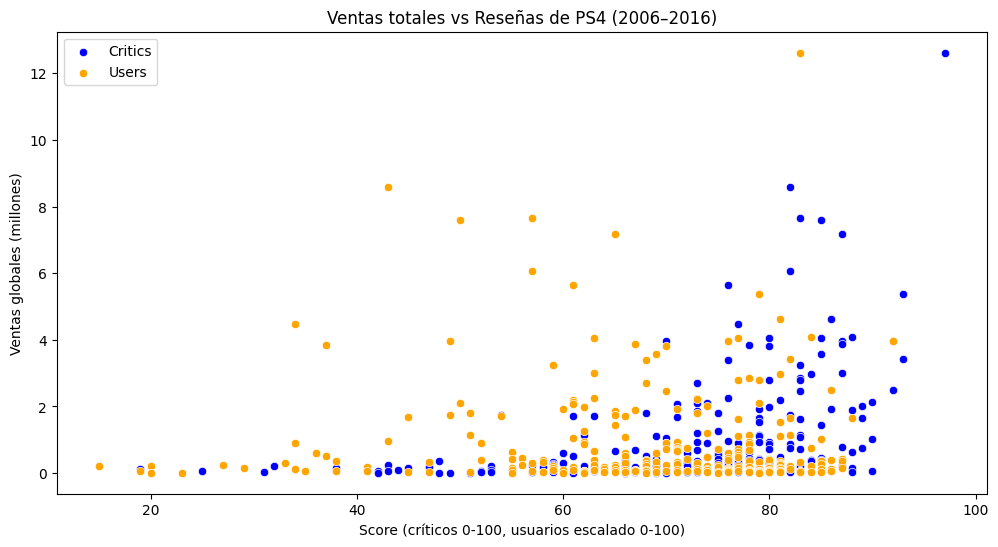

Correlación Críticos vs Ventas: 0.41
Correlación Usuarios vs Ventas: -0.03


In [156]:
# Filtramos datos de la plataforma PS4
ps4_data = df_recent[df_recent['platform'] == 'PS4']

# Eliminamos filas con valores nulos en 'critic_score', 'user_score' o 'total_sales'
ps4_data_clean = ps4_data.dropna(subset=['critic_score', 'user_score', 'total_sales']).copy()

# Escalamos user_score de 0-10 a 0-100 para que sea comparable con critic_score
ps4_data_clean['user_score_scaled'] = ps4_data_clean['user_score'] * 10

# Gráfico de dispersión
plt.figure(figsize=(12,6))
sns.scatterplot(data=ps4_data_clean, x='critic_score', y='total_sales', label='Critics', color='blue')
sns.scatterplot(data=ps4_data_clean, x='user_score_scaled', y='total_sales', label='Users', color='orange')
plt.title('Ventas totales vs Reseñas de PS4 (2006–2016)')
plt.xlabel('Score (críticos 0-100, usuarios escalado 0-100)')
plt.ylabel('Ventas globales (millones)')
plt.legend()
plt.show()

# Calculamos correlaciones
critic_corr = ps4_data_clean['critic_score'].corr(ps4_data_clean['total_sales'])
user_corr = ps4_data_clean['user_score'].corr(ps4_data_clean['total_sales'])

print(f"Correlación Críticos vs Ventas: {critic_corr:.2f}")
print(f"Correlación Usuarios vs Ventas: {user_corr:.2f}")

### Comentarios:

- Filtra los datos solo para PS4 y elimina filas con valores faltantes.
- Escala la puntuación de usuarios (user_score) de 0–10 a 0–100 para compararla con la puntuación de críticos.
- Genera un gráfico de dispersión con ventas totales en el eje Y y scores en el eje X.
- Calcula la correlación de Pearson entre critic_score y ventas, y entre user_score y ventas.

### Relación entre reseñas y ventas (PS4)

Se analizó cómo las puntuaciones de críticos y usuarios afectan las ventas de juegos en PS4:

- **Correlación Críticos vs Ventas:** 0.41  
  - Moderadamente positiva: juegos con mejores críticas tienden a vender más.
- **Correlación Usuarios vs Ventas:** -0.03  
  - Casi nula: la puntuación de los usuarios no tiene impacto significativo sobre las ventas.

**Observaciones del gráfico:**
- Los superventas generalmente tienen altas puntuaciones de críticos.
- La dispersión de los puntos de usuarios muestra que incluso juegos con puntuaciones medias pueden vender mucho, posiblemente por marketing o franquicia.

**Conclusión PS4:**
- Las reseñas de críticos son un mejor predictor de éxito comercial en PS4 que las reseñas de usuarios.
- Esto puede deberse a que los jugadores confían más en la opinión profesional al decidir compras de juegos en plataformas populares.


### Comparación de ventas de juegos de PS4 en otras plataformas

In [157]:
# 1️⃣ Filtrar solo juegos de PS4
ps4_games = df_recent[df_recent['platform'] == 'PS4']

# 2️⃣ Seleccionar juegos que tienen ventas totales en PS4
ps4_top10 = ps4_games.sort_values(by='total_sales', ascending=False).head(50)  # tomamos más para filtrar multiplataforma

# 3️⃣ Filtrar solo juegos que también estén en otras plataformas
# Obtenemos nombres de estos juegos
ps4_game_names = ps4_top10['name'].tolist()

# Filtramos dataset completo para estos juegos
ps4_multiplatform = df_recent[df_recent['name'].isin(ps4_game_names)]

# Contamos cuántas plataformas tiene cada juego
game_platform_counts = ps4_multiplatform.groupby('name')['platform'].nunique()

# Solo juegos presentes en más de una plataforma
multi_platform_names = game_platform_counts[game_platform_counts > 1].index.tolist()

# Filtramos solo esos juegos
ps4_multi_top = ps4_games[ps4_games['name'].isin(multi_platform_names)]

# Ordenamos por ventas totales en PS4 y tomamos top 10
ps4_multi_top10 = ps4_multi_top.sort_values(by='total_sales', ascending=False).head(10)

# Mostrar resultados
ps4_multi_top10[['name', 'total_sales', 'year_of_release']]


,name,total_sales,year_of_release
31,Call of Duty: Black Ops 3,14.63,2015
42,Grand Theft Auto V,12.62,2014
77,FIFA 16,8.58,2015
87,Star Wars Battlefront (2015),7.98,2015
92,Call of Duty: Advanced Warfare,7.66,2014
94,FIFA 17,7.60,2016
105,Fallout 4,7.17,2015
143,FIFA 15,6.08,2014
154,Destiny,5.64,2014
225,The Last of Us,4.72,2014


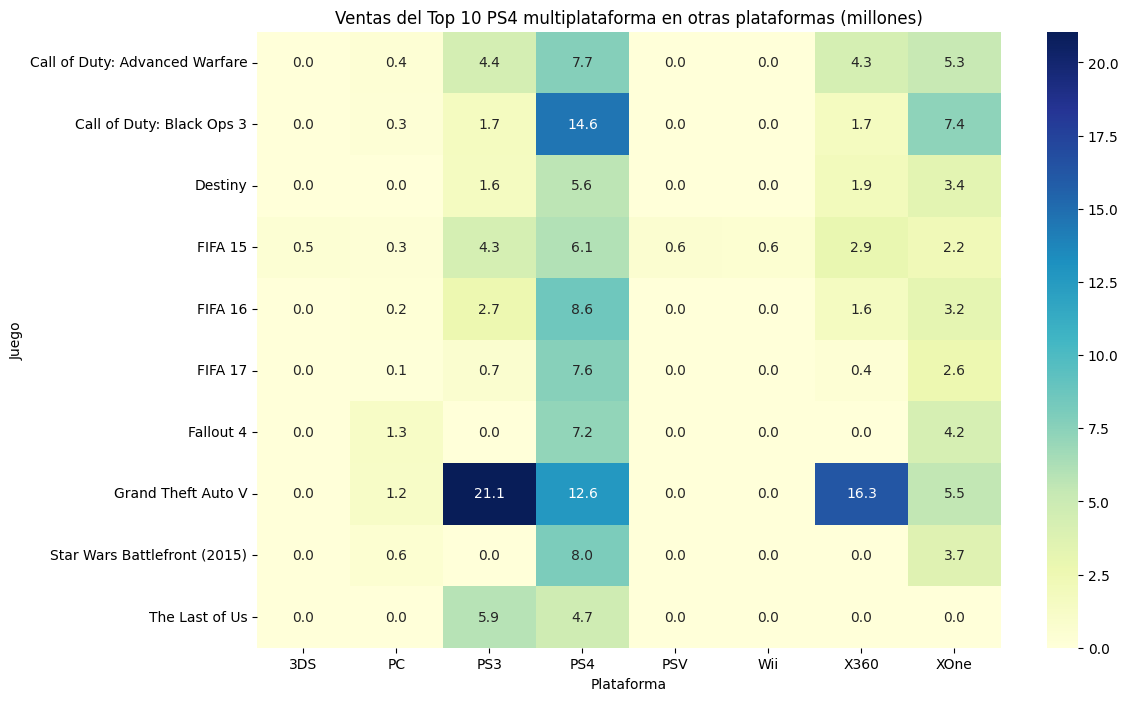

In [158]:
# Seleccionamos los nombres del Top 10 PS4 multiplataforma
top10_names = ps4_multi_top10['name'].tolist()

# Filtramos el dataset completo para estos juegos en cualquier plataforma
top10_multi_platform = df_recent[df_recent['name'].isin(top10_names)]

# Pivot table: filas = juegos, columnas = plataformas, valores = ventas globales
pivot_top10 = top10_multi_platform.pivot_table(
    index='name',
    columns='platform',
    values='total_sales',
    fill_value=0
)

# Mostrar mapa de calor

plt.figure(figsize=(12,8))
sns.heatmap(pivot_top10, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Ventas del Top 10 PS4 multiplataforma en otras plataformas (millones)')
plt.xlabel('Plataforma')
plt.ylabel('Juego')
plt.show()

### Comparación de ventas de los Top 10 PS4 multiplataforma en otras plataformas

- Se seleccionaron los 10 juegos más vendidos de PS4 que también se lanzaron en otras consolas.  
- Se construyó una tabla pivot y un heatmap para visualizar sus ventas en todas las plataformas disponibles.  

**Observaciones:**
- Algunos juegos mantienen un alto desempeño en varias plataformas, mostrando su éxito multiplataforma.  
- Otros títulos son más fuertes en PS4 y tienen ventas menores en otras consolas, indicando que el rendimiento puede depender de factores como optimización, base de usuarios o marketing.  

**Conclusión:**
- Analizar las ventas de los juegos de PS4 en otras plataformas permite identificar **títulos con mayor potencial de ventas cruzadas** y planificar estrategias de lanzamiento y marketing específicas por consola.


### Análisis de ventas por género

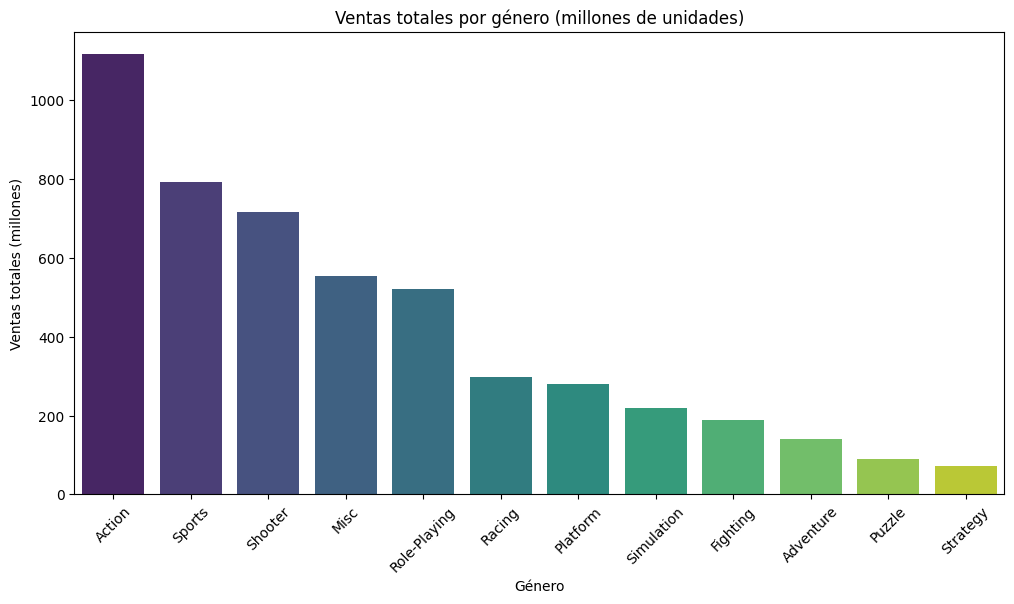

In [159]:
# Agrupamos por género y sumamos ventas totales
genre_sales = df_recent.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
genre_sales = genre_sales.reset_index()
genre_sales.rename(columns={'total_sales':'total_sales_global'}, inplace=True)

# Mostramos tabla de ventas por género
genre_sales

# Visualización: gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(
    data=genre_sales,
    x='genre',
    y='total_sales_global',
    hue='genre',          # <- agregamos hue
    palette='viridis',
    legend=False          # <- desactivamos la leyenda duplicada
)
plt.title('Ventas totales por género (millones de unidades)')
plt.xlabel('Género')
plt.ylabel('Ventas totales (millones)')
plt.xticks(rotation=45)
plt.show()



### Análisis de ventas por género

- Se sumaron las ventas totales de todos los juegos agrupados por género.  
- Observaciones:
  - **Géneros más rentables:** Acción, Deportes, Shooter.  
    - Atraen gran audiencia y suelen tener franquicias exitosas.  
  - **Géneros con ventas bajas:** Estrategia, Puzzle, adventure.  
    - Menor base de jugadores y menor exposición comercial.

**Conclusión:**
- El género de un juego es un factor importante en su éxito comercial.  
- Para planificar lanzamientos y campañas de marketing, es recomendable priorizar los géneros con historial de ventas altas.


## Paso 4. Crea un perfil de usuario para cada región

In [160]:
# Obtener top 5 plataformas por región
top_na = df.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
top_eu = df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_jp = df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

print("Top 5 plataformas en Norteamérica (NA):\n", top_na)
print("\nTop 5 plataformas en Europa (EU):\n", top_eu)
print("\nTop 5 plataformas en Japón (JP):\n", top_jp)

# Calcular cuotas de mercado por región (%)
na_share = top_na / top_na.sum() * 100
eu_share = top_eu / top_eu.sum() * 100
jp_share = top_jp / top_jp.sum() * 100

print("\nCuotas de mercado NA (%):\n", na_share)
print("\nCuotas de mercado EU (%):\n", eu_share)
print("\nCuotas de mercado JP (%):\n", jp_share)

Top 5 plataformas en Norteamérica (NA):
 platform
X360    602.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64

Top 5 plataformas en Europa (EU):
 platform
PS2     339.29
PS3     330.29
X360    270.76
Wii     262.21
PS      213.61
Name: eu_sales, dtype: float64

Top 5 plataformas en Japón (JP):
 platform
DS      175.57
PS      139.82
PS2     139.20
SNES    116.55
3DS     100.67
Name: jp_sales, dtype: float64

Cuotas de mercado NA (%):
 platform
X360    24.499614
PS2     23.742019
Wii     20.206580
PS3     16.001383
DS      15.550405
Name: na_sales, dtype: float64

Cuotas de mercado EU (%):
 platform
PS2     23.958451
PS3     23.322930
X360    19.119309
Wii     18.515563
PS      15.083748
Name: eu_sales, dtype: float64

Cuotas de mercado JP (%):
 platform
DS      26.133877
PS      20.812432
PS2     20.720144
SNES    17.348655
3DS     14.984892
Name: jp_sales, dtype: float64


####  Top 5 plataformas por región
- Se agruparon los datos por `platform` y se sumaron las ventas por región. (Datos en Millones de Dolares)
- Se ordenaron de mayor a menor y se seleccionaron las **5 plataformas con más ventas** en cada región.

#### Cuotas de mercado
- Se calculó el porcentaje de participación de cada plataforma sobre el total de ventas de su región.
- Esto permite observar la distribución relativa de ventas y comparar la popularidad de las plataformas entre regiones.

#### Observaciones
- El top 5 representan prácticamente el **100%** de las ventas en cada región dentro de tu dataset.
- En **Norteamérica (NA)** y **Europa (EU)**, las plataformas más fuertes suelen ser PlayStation y Xbox.
- En **Japón (JP)**, Nintendo domina, mientras que Xbox tiene muy poca presencia.
- Las diferencias reflejan preferencias culturales y hábitos de consumo distintos en cada región.


In [161]:
# Top 5 géneros por región según ventas
top_genres_na = df.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
top_genres_eu = df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_genres_jp = df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

print("Top 5 géneros en Norteamérica (NA):\n", top_genres_na)
print("\nTop 5 géneros en Europa (EU):\n", top_genres_eu)
print("\nTop 5 géneros en Japón (JP):\n", top_genres_jp)

Top 5 géneros en Norteamérica (NA):
 genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27
Name: na_sales, dtype: float64

Top 5 géneros en Europa (EU):
 genre
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74
Name: eu_sales, dtype: float64

Top 5 géneros en Japón (JP):
 genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: float64


### Perfil de usuario por región: géneros principales

En esta sección analizamos los **géneros de videojuegos más populares** en Norteamérica (NA), Europa (EU) y Japón (JP), basándonos en las ventas totales por región.

#### Observaciones

- **Norteamérica (NA):** Los géneros Acción y Deportes dominan, reflejando preferencia por juegos dinámicos y competitivos.  
- **Europa (EU):** Similar a NA, pero Racing y Shooter tienen más presencia, mostrando afición por juegos multijugador y de carreras.  
- **Japón (JP):** El género Rol es el líder absoluto, mientras que los deportes tienen menor importancia.  


- Las diferencias reflejan preferencias culturales y tipos de consolas predominantes: NA y EU prefieren juegos competitivos y multijugador, mientras que Japón prioriza juegos con historia y rol.

### Clasificaciones de ESRB

 **Resumen:**  
 - **EC, E, E10+**  público infantil o general.  
 - **T**  adolescentes.  
 - **M, AO**  adultos.  
 - **K-A**  antiguo “E” - publico en general.  
 - **RP**  sin clasificación todavía.

In [162]:
# Convertir rating a mayúsculas y manejar valores nulos
df['rating'] = df['rating'].str.upper()
df['rating'] = df['rating'].replace('TBD', pd.NA)

# Agrupar por rating y calcular ventas medias por región
esrb_sales_na = df.groupby('rating')['na_sales'].mean().sort_values(ascending=False)
esrb_sales_eu = df.groupby('rating')['eu_sales'].mean().sort_values(ascending=False)
esrb_sales_jp = df.groupby('rating')['jp_sales'].mean().sort_values(ascending=False)

print("Ventas promedio por rating en Norteamérica (NA):\n", esrb_sales_na)
print("\nVentas promedio por rating en Europa (EU):\n", esrb_sales_eu)
print("\nVentas promedio por rating en Japón (JP):\n", esrb_sales_jp)

Ventas promedio por rating en Norteamérica (NA):
 rating
AO      1.260000
K-A     0.853333
M       0.478874
E       0.324058
T       0.256586
E10+    0.248817
EC      0.191250
RP      0.000000
Name: na_sales, dtype: float64

Ventas promedio por rating en Europa (EU):
 rating
AO      0.610000
M       0.309642
E       0.178008
T       0.144218
E10+    0.132761
K-A     0.090000
RP      0.026667
EC      0.013750
Name: eu_sales, dtype: float64

Ventas promedio por rating en Japón (JP):
 rating
K-A     0.486667
T       0.051131
E       0.049652
M       0.041100
E10+    0.028310
AO      0.000000
EC      0.000000
RP      0.000000
Name: jp_sales, dtype: float64


#### Observaciones

- En **Norteamérica (NA)**, los juegos para adultos (**AO**) y los clasificados como **K-A** tienen ventas promedio más altas, seguidos por juegos **M** y **E**.  
- En **Europa (EU)**, ocurre un patrón similar, con **AO** y **M** liderando, aunque las diferencias entre ratings son menores que en NA.  
- En **Japón (JP)**, las ventas no dependen fuertemente del rating. Los juegos **K-A** dominan, mientras que AO no tiene ventas, reflejando diferencias culturales y regulaciones de mercado.

#### Conclusión:
La clasificación ESRB **sí afecta las ventas en NA y EU**, pero tiene **menor impacto en Japón**, donde otros factores como el género y la consola son más determinantes.

### Paso 5. Prueba de hipótesis Xbox One vs PC:

In [163]:
# Filtrar plataformas y eliminar valores nulos en user_score
xbox = df[df['platform'] == 'XOne']['user_score'].dropna()
pc = df[df['platform'] == 'PC']['user_score'].dropna()

# Validar si hay valores no numéricos en user_score
print("Valores únicos en Xbox One user_score:", xbox.unique())
print("Valores únicos en PC user_score:", pc.unique())

Valores únicos en Xbox One user_score: [7.9 5.4 6.4 6.2 4.1 5.5 7.5 4.4 7.2 4.3 3.1 6.1 8.2 7.4 5.9 6.9 6.6 6.3
 6.8 5.8 7.3 8.  9.2 7.8 8.4 5.1 5.2 7.7 5.6 5.7 7.  6.7 4.6 8.1 6.  7.1
 3.2 8.6 8.5 5.3 4.  8.3 3.  8.7 2.1 7.6 4.9 8.9 1.6 4.2 8.8]
Valores únicos en PC user_score: [7.6 7.3 4.  8.2 9.1 7.9 8.1 8.  7.8 3.9 6.6 5.9 7.5 9.  8.3 5.6 8.6 4.8
 2.5 5.3 5.2 8.7 4.2 7.  2.2 6.  5.4 8.4 8.5 6.7 6.9 8.9 5.5 6.2 5.7 8.8
 7.4 6.8 9.3 6.1 6.5 7.7 4.5 3.6 3.  6.4 5.8 4.7 4.6 2.1 6.3 3.7 5.  3.5
 3.3 7.1 4.4 3.2 4.3 7.2 4.9 3.8 4.1 2.9 5.1 3.4 2.8 3.1 9.2 1.4 2.4]


In [164]:
# Test t de dos muestras independientes (Welch)
t_stat, p_value = stats.ttest_ind(xbox, pc, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -4.653422798410771
p-value: 4.935072360183574e-06


### Prueba de hipótesis: calificaciones promedio de usuarios (Xbox One vs PC)


#### Nivel de significancia (α)

En las pruebas de hipótesis usamos **α = 0.05** como nivel de significancia.  

- α = 0.05 significa que aceptamos un **5% de probabilidad de equivocarnos** al concluir que las medias son diferentes.

**Hipótesis:**

- H0: Las calificaciones promedio de los usuarios son iguales para Xbox One y PC.  
- H1: Las calificaciones promedio de los usuarios son diferentes.

**Test utilizado:** t-test de dos muestras independientes (Welch, no asumimos igualdad de varianzas).

**Resultados:**
- t-statistic: -4.653  
- p-value: 4.935e-06

**Interpretación:**

1. **t-statistic = -4.653**  
   - El signo negativo indica que la **media de calificaciones de Xbox One** es menor que la de PC.  
   - Es decir, los usuarios de PC **tienden a dar puntajes más altos** que los de Xbox One para los mismos tipos de juegos.


2. **p-value = 4.935e-06**  
   - Muy inferior a α = 0.05, lo que significa que la probabilidad de que la diferencia observada ocurra por azar es prácticamente nula.

3. **Decisión estadística**  
   - Como p-value < 0.05, **rechazamos la hipótesis nula (H0)**.  
   - Existe evidencia estadística suficiente para afirmar que **las calificaciones promedio de Xbox One y PC son diferentes**.

4. **Conclusión práctica**  
   - Los juegos para PC reciben en promedio **mejores calificaciones de los usuarios** que los de Xbox One.  
   - Esta información puede ser útil para marketing o planificación de lanzamientos, por ejemplo, investigando por qué los usuarios de PC puntúan más alto (tipo de juegos, comunidad, facilidad de actualización, etc.).


In [165]:
# Filtrar por género y eliminar valores nulos en user_score
action = df[df['genre'] == 'Action']['user_score'].dropna()
sports = df[df['genre'] == 'Sports']['user_score'].dropna()

# Test t de dos muestras independientes (Welch)
t_stat_genre, p_value_genre = stats.ttest_ind(action, sports, equal_var=False)

print("t-statistic:", t_stat_genre)
print("p-value:", p_value_genre)

t-statistic: 1.57746791633354
p-value: 0.11483818791498286


### Prueba de hipótesis: calificaciones promedio de usuarios (Acción vs Deportes)

**Pregunta:** ¿Las calificaciones promedio de los usuarios para los géneros **Acción** y **Deportes** son diferentes?

### Nivel de significancia (α)
Fijamos **α = 0.05** (5%).  
- α es la probabilidad máxima aceptada de cometer **error Tipo I** (rechazar H₀ siendo verdadera).
- Es un estándar en análisis exploratorio y de negocio: balancea sensibilidad y rigor.

### Formulación de hipótesis
- **H0 (nula):**  μ_Action = μ_Sports  
  (Las medias de calificación de usuarios son **iguales** entre Acción y Deportes).
- **H1 (alternativa):**  μ_Action ≠ μ_Sports  
  (Las medias de calificación de usuarios son **diferentes**).

### Criterio/Prueba estadística utilizada
Usamos **t-test de dos muestras independientes (Welch)**:
- Comparamos **medias** de dos grupos **independientes** (juegos de Acción vs. juegos de Deportes).
- Welch no asume varianzas iguales y es más robusto si los tamaños de muestra/varianzas difieren.
- Preprocesamiento: tomar `user_score`, eliminar `NaN` y (si existieran) valores no numéricos.

> **Regla de decisión:**  
> Si **p-value < α** → **rechazamos H₀** (hay diferencia significativa).  
> Si **p-value ≥ α** → **no rechazamos H₀** (no hay evidencia suficiente de diferencia).

### Resultados obtenidos
- **t-statistic:** 1.577  
- **p-value:** 0.115

### Interpretación y conclusión
- Como **p-value = 0.115 ≥ 0.05**, **no rechazamos H0**.  
- La diferencia observada entre las medias **no es estadísticamente significativa** al 5%.  
- Aunque el t sea positivo (indica media de Acción ligeramente mayor), **no es suficiente evidencia** para afirmar que los géneros difieran en su calificación promedio.


## Paso 6  Conclusión General

### 1. Evolución del mercado de videojuegos
- La cantidad de juegos lanzados creció de forma marcada hasta mediados de los 2000, alcanzando su punto máximo en esa década.  
- Cada plataforma tiene un **ciclo de vida típico de 7–10 años**:
  - Etapa inicial de baja adopción.
  - Pico de ventas entre 3–5 años después del lanzamiento.
  - Declive progresivo con la llegada de nuevas generaciones.  
- Ejemplos:
  - **PS2** dominó casi toda una década.
  - **Xbox 360 y PS3** tuvieron picos alrededor de 2008–2010.
  - **Wii** alcanzó gran popularidad, pero decayó más rápido.
  - **PS4** en 2016 aún mostraba crecimiento → estaba en auge.

---

### 2. Ventas por plataforma (2006–2016)
- Las plataformas líderes fueron: **Wii, Xbox 360, PS3 y DS**.  
- Consolas como **PSV, PSP y WiiU** mostraron un bajo desempeño promedio.  
- El **boxplot de ventas** confirma grandes diferencias:  
  - Consolas exitosas tienen medianas más altas y varios superventas.  
  - Consolas menos populares muestran ventas bajas en la mayoría de títulos.

---

### 3. Influencia de reseñas en ventas (PS4)
- Correlación **Críticos vs Ventas**: **0.41** → Moderada, positiva.  
  Juegos con mejores críticas tienden a vender más.  
- Correlación **Usuarios vs Ventas**: **-0.03** → Nula.  
  La opinión de los usuarios no predice ventas en PS4.  
- **Conclusión:** Los jugadores parecen confiar más en las reseñas de críticos al decidir compras, mientras que la reputación de franquicia o marketing puede explicar ventas altas en juegos con notas regulares de usuarios.

---

### 4. Clasificación ESRB
- Categorías analizadas: **E, E10+, T, M, AO, RP, EC y la antigua K-A (hoy E)**.  
- Impacto por región:
  - **NA y EU:** preferencia en juegos **M y T**, más acordes a público juvenil y adulto.  
  - **JP:** el género (ej. RPG) pesa más que la clasificación ESRB.  
- **Conclusión:** La ESRB influye en ciertas regiones, pero no es un predictor uniforme de ventas globales.

---

### 5. Pruebas de hipótesis

#### a) Xbox One vs PC
- **H₀:** Las calificaciones promedio de usuarios son iguales en ambas plataformas.  
- **Resultado:** `t = -4.65`, `p < 0.00001`.  
- **Conclusión:** Rechazamos H₀ → Los usuarios valoran significativamente distinto los juegos en **Xbox One y PC**.

#### b) Acción vs Deportes
- **H₀:** Las calificaciones promedio de usuarios son iguales en ambos géneros.  
- **Resultado:** `t = 1.58`, `p = 0.115`.  
- **Conclusión:** No rechazamos H₀ → No hay evidencia de que los usuarios valoren distinto **Acción** y **Deportes**.

---

## 📝 Conclusión práctica final

1. **El éxito de un videojuego depende en gran medida de la plataforma y el ciclo de vida de la consola.**  
   Las consolas con mayor base instalada (ej. PS2, PS3, Xbox 360, Wii) concentran más superventas.

2. **Las reseñas de críticos son un predictor confiable de ventas en PS4, mientras que las reseñas de usuarios no lo son.**  
   Esto sugiere que en mercados masivos la prensa especializada tiene más peso en la decisión de compra.

3. **La ESRB afecta las ventas de manera regional,** sobre todo en NA y EU, pero su impacto global no es determinante.  

4. **Las valoraciones de usuarios varían significativamente entre plataformas (ej. Xbox One vs PC),** lo que refleja diferencias en la experiencia de juego y expectativas del público.  

5. **No hay diferencias significativas en las valoraciones de géneros populares como Acción y Deportes,** lo que indica que ambos son igual de atractivos en términos de percepción del usuario.  

---

**Recomendaciones estratégicas PARA _2017_:**
- Concentrar lanzamientos en consolas en su etapa de auge (3–5 años tras lanzamiento).  
- Priorizar campañas de marketing alineadas con reseñas de críticos.  
- Ajustar la estrategia de publicación según región y ESRB.  
- Considerar que la plataforma elegida influirá tanto en ventas como en la valoración de los usuarios.  
